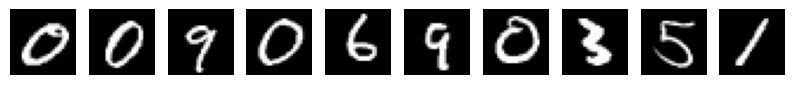

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Загрузка данных MNIST
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Визуализация данных
def visualize_data(loader, num_images=10):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

visualize_data(trainloader)

# Визуализация реконструкции
def visualize_reconstruction(loader, model, num_images=10):
    dataiter = iter(loader)
    images, _ = next(dataiter)
    images = images.view(images.size(0), -1)
    outputs = model(images.to(device))
    
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Оригинальные изображения
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(28, 28).detach().cpu().numpy(), cmap='gray')
        plt.axis('off')
        
        # Восстановленные изображения
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(outputs[i].reshape(28, 28).detach().cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

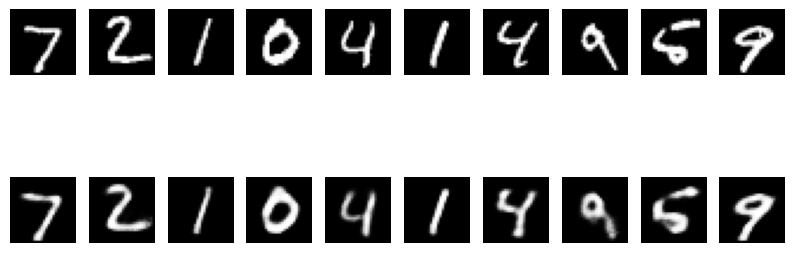

In [12]:
# Инициализация модели и оптимизатора
model = Autoencoder().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
for epoch in range(10):
    progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}', leave=False)
    for data in progress_bar:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        output = model(img)
        loss = criterion(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        progress_bar.set_postfix(loss=loss.item())
    
    # tqdm.write(f'Epoch {epoch+1}, Loss: {loss.item():.3f}')

visualize_reconstruction(testloader, model)

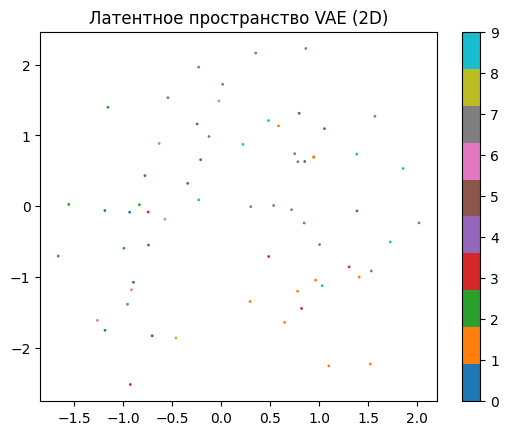

In [13]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, 20)  # mu
        self.fc22 = nn.Linear(400, 20)  # logvar
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 28*28)
    
    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Функция потерь для VAE
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Инициализация модели и оптимизатора
model_vae = VAE().to(device)
optimizer_vae = optim.Adam(model_vae.parameters(), lr=0.001)

# Обучение VAE
for epoch in range(10):
    progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}', leave=False)
    for data in progress_bar:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        recon_batch, mu, logvar = model_vae(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        
        optimizer_vae.zero_grad()
        loss.backward()
        optimizer_vae.step()
        
        progress_bar.set_postfix(loss=loss.item())
    

# Визуализация латентного пространства
def visualize_latent_space(loader, model):
    model.eval()
    with torch.no_grad():
        for data in loader:
            img, labels = data
            img = img.view(img.size(0), -1)
            img = img.to(device)
            mu, _ = model.encode(img)
            plt.scatter(mu[:, 0].cpu().numpy(), mu[:, 1].cpu().numpy(), c=labels, cmap='tab10', s=1)
            plt.colorbar()
            plt.title("Латентное пространство VAE (2D)")
            plt.show()
            break

visualize_latent_space(testloader, model_vae)

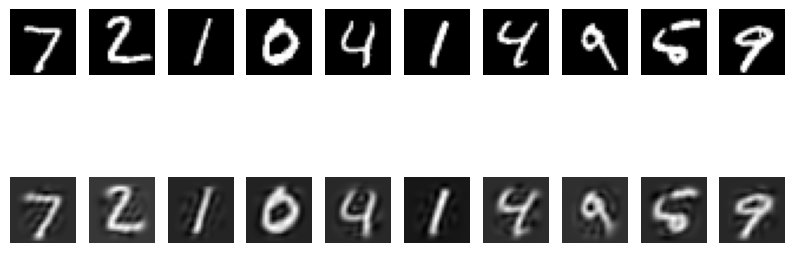

In [14]:
from sklearn.decomposition import PCA

# Преобразование данных в одномерный массив
x_train_flat = trainset.data.numpy().reshape(len(trainset), -1)
x_test_flat = testset.data.numpy().reshape(len(testset), -1)

# Реализация PCA
pca = PCA(n_components=64)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

# Обратное преобразование для визуализации реконструкции
x_train_reconstructed = pca.inverse_transform(x_train_pca)
x_test_reconstructed = pca.inverse_transform(x_test_pca)

# Визуализация реконструкции PCA
def visualize_pca_reconstruction(original, reconstructed, num_images=10):
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Оригинал
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        
        # Восстановление
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

visualize_pca_reconstruction(x_test_flat, x_test_reconstructed)

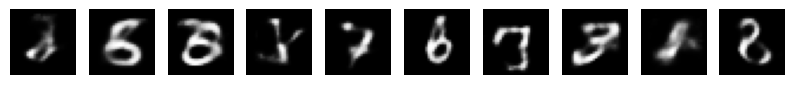

In [18]:
# Генерация случайных точек в латентном пространстве VAE
latent_samples = torch.randn(10, 20)
generated_images = model_vae.decode(latent_samples.to(device)).view(-1, 28, 28)

# Визуализация сгенерированных изображений
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_images[i].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

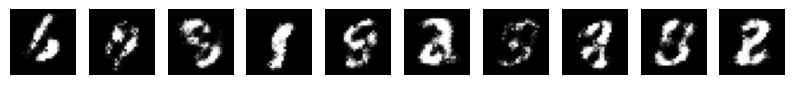

In [22]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

# Инициализация GAN
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

# Обучение GAN
# Обучение GAN
for epoch in range(10):
    progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}', leave=False)
    for i, (imgs, _) in enumerate(progress_bar):
        imgs = imgs.to(device)
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)
        
        # Обучение дискриминатора
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(imgs), real_labels)
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()
        
        # Обучение генератора
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)
        g_loss = criterion(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()
        
        progress_bar.set_postfix(D_loss=d_loss.item(), G_loss=g_loss.item())


# Генерация изображений с помощью GAN
z = torch.randn(10, latent_dim).to(device)
generated_images = generator(z)

# Визуализация сгенерированных изображений
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_images[i].squeeze().detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()